In [1]:
import os
import xarray as xr
import rasterio
from rasterio.transform import Affine

import datetime
from tqdm import tqdm

import numpy as np

## 查看数据

In [2]:
ds = xr.open_dataset('../../JupyterLab/2024 math/data/0.25 Degree Rain(1961-2022)/CHM_PRE_0.25dg_19612022.nc/CHM_PRE_0.25dg_19612022.nc')
ds  # 查看其维度、刻度、变量等信息

<xarray.Dataset>
Dimensions:         (longitude: 256, latitude: 144, years: 62, time: 22645)
Coordinates:
  * longitude       (longitude) float64 72.12 72.38 72.62 ... 135.4 135.6 135.9
  * latitude        (latitude) float64 18.12 18.38 18.62 ... 53.38 53.62 53.88
  * years           (years) float64 1.961e+03 1.962e+03 ... 2.021e+03 2.022e+03
  * time            (time) datetime64[ns] 1961-01-01 1961-01-02 ... 2022-12-31
Data variables:
    pre             (time, latitude, longitude) float32 ...
    station_number  (years, latitude, longitude) float32 ...
Attributes:
    Title:               IDW + PRISM: China gridded daily precipitation
    Institution:         Data held at Beijing Normal University, China
    History:             Last updated on 30-Apr-2023
    Time scale:          1961-01-01 to 2022-12-31
    Time resolution:     daily
    Spatial extent:      18°N–54°N, 72°E–136°E
    Spatial resolution:  0.25° × 0.25°
    Contact:             miaocy@bnu.edu.cn

In [3]:
ds['years']

<xarray.DataArray 'years' (years: 62)>
array([1961., 1962., 1963., 1964., 1965., 1966., 1967., 1968., 1969., 1970.,
       1971., 1972., 1973., 1974., 1975., 1976., 1977., 1978., 1979., 1980.,
       1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988., 1989., 1990.,
       1991., 1992., 1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000.,
       2001., 2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009., 2010.,
       2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019., 2020.,
       2021., 2022.])
Coordinates:
  * years    (years) float64 1.961e+03 1.962e+03 ... 2.021e+03 2.022e+03
Attributes:
    standard_name:  years
    calendar:       years

In [4]:
ds['years'][0]

<xarray.DataArray 'years' ()>
array(1961.)
Coordinates:
    years    float64 1.961e+03
Attributes:
    standard_name:  years
    calendar:       years

In [5]:
ds['pre']

<xarray.DataArray 'pre' (time: 22645, latitude: 144, longitude: 256)>
[834785280 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float64 72.12 72.38 72.62 72.88 ... 135.4 135.6 135.9
  * latitude   (latitude) float64 18.12 18.38 18.62 18.88 ... 53.38 53.62 53.88
  * time       (time) datetime64[ns] 1961-01-01 1961-01-02 ... 2022-12-31
Attributes:
    long_name:  daily precipitation
    units:      mm/day

## 转换

In [6]:
data_var = ds['pre']
data_var

<xarray.DataArray 'pre' (time: 22645, latitude: 144, longitude: 256)>
[834785280 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float64 72.12 72.38 72.62 72.88 ... 135.4 135.6 135.9
  * latitude   (latitude) float64 18.12 18.38 18.62 18.88 ... 53.38 53.62 53.88
  * time       (time) datetime64[ns] 1961-01-01 1961-01-02 ... 2022-12-31
Attributes:
    long_name:  daily precipitation
    units:      mm/day

In [7]:
specific_time = '1990-01-01'
data_at_time = data_var.sel(time=specific_time)
data_at_time

<xarray.DataArray 'pre' (latitude: 144, longitude: 256)>
[36864 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float64 72.12 72.38 72.62 72.88 ... 135.4 135.6 135.9
  * latitude   (latitude) float64 18.12 18.38 18.62 18.88 ... 53.38 53.62 53.88
    time       datetime64[ns] 1990-01-01
Attributes:
    long_name:  daily precipitation
    units:      mm/day

In [8]:
def nc_to_tiff(in_put, out_put, date):
    # 获取经纬度范围
    min_lon = data_at_time.coords['longitude'].min()
    max_lon = data_at_time.coords['longitude'].max()
    min_lat = data_at_time.coords['latitude'].min()
    max_lat = data_at_time.coords['latitude'].max()
    
    
    pixel_size = 0.25
    
    # 创建仿射变换矩阵
    transform = Affine(
        pixel_size,  # 像素宽度
        0.0,
        min_lon,  # 左上角经度
        0.0,
        pixel_size,  # 像素高度（注意负号）
        min_lat  # 左上角纬度
    )
    
    width = data_at_time.sizes['longitude']
    height = data_at_time.sizes['latitude']
    
    # 创建 GeoTIFF 配置
    profile = {
        'driver': 'GTiff',
        'crs': 'EPSG:4326',  # Assuming WGS84
        'transform': transform,
        'count': 1,  # Number of bands 
        'dtype': data_at_time.dtype,
        'width': width,
        'height': height
    }
    
    # 写入 GeoTIFF
    with rasterio.open(out_put+date+'.tif', 'w', **profile) as dst:
        dst.write(data_at_time.values, 1)

def generate_date_list(start_date, end_date):
  start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
  end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")
  date_list = [date.strftime("%Y-%m-%d") for date in daterange(start_date, end_date)]
  return date_list

def daterange(start_date, end_date):
  for n in range(int((end_date - start_date).days)):
    yield start_date + datetime.timedelta(n)

In [9]:
start_date = "1990-01-01"
end_date = "2020-12-31"
date_list = generate_date_list(start_date, end_date)

tif_dir = 'data/0.25 Degree Rain(1961-2022)/TIF/'

In [10]:
# 转换
for date in tqdm(date_list, desc="Processing dates"):
    data_at_time = data_var.sel(time=date)
    nc_to_tiff(data_at_time, tif_dir, date)

Processing dates: 100%|██████████████████████████████████████████████████████████| 11322/11322 [26:48<00:00,  7.04it/s]


## 可视化

In [1]:
import os
import numpy as np
import pandas as pd

import geopandas as gpd
from osgeo import gdal

import matplotlib.pyplot as plt

In [2]:
def get_values(tif_path, name):
    ds = gdal.Open(tif_path)
    if ds is None:
        print('Could not open file')
        return []

    # 获取栅格的基本信息
    cols = ds.RasterXSize
    rows = ds.RasterYSize
    gt = ds.GetGeoTransform()

    # 准备存储结果
    value = []
    lon = []
    lat = []
    # 遍历每一个栅格单元
    for row in range(rows):
        for col in range(cols): 
            # 计算中心坐标
            lon.append(gt[0] + (col + 0.5) * gt[1] + (row + 0.5) * gt[2])
            lat.append(gt[3] + (col + 0.5) * gt[4] + (row + 0.5) * gt[5])
            # 提取中心点处的值
            band = ds.GetRasterBand(1)
            
            value.append(band.ReadAsArray(col, row, 1, 1)[0][0])

    return pd.DataFrame(data={'lon':lon,'lat':lat,name:value})

In [2]:
gdf = gpd.read_file('../../z_GIS_Data/矢量/2023年省级/2023年省级.shp')

In [4]:
df = get_values('data/0.25 Degree Rain(1961-2022)/TIF/2020-08-08.tif', '2020-08-08')
df = df[df['2020-08-08']!=-99.9]

In [5]:
gdf0 = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon,df.lat), crs=gdf.crs)

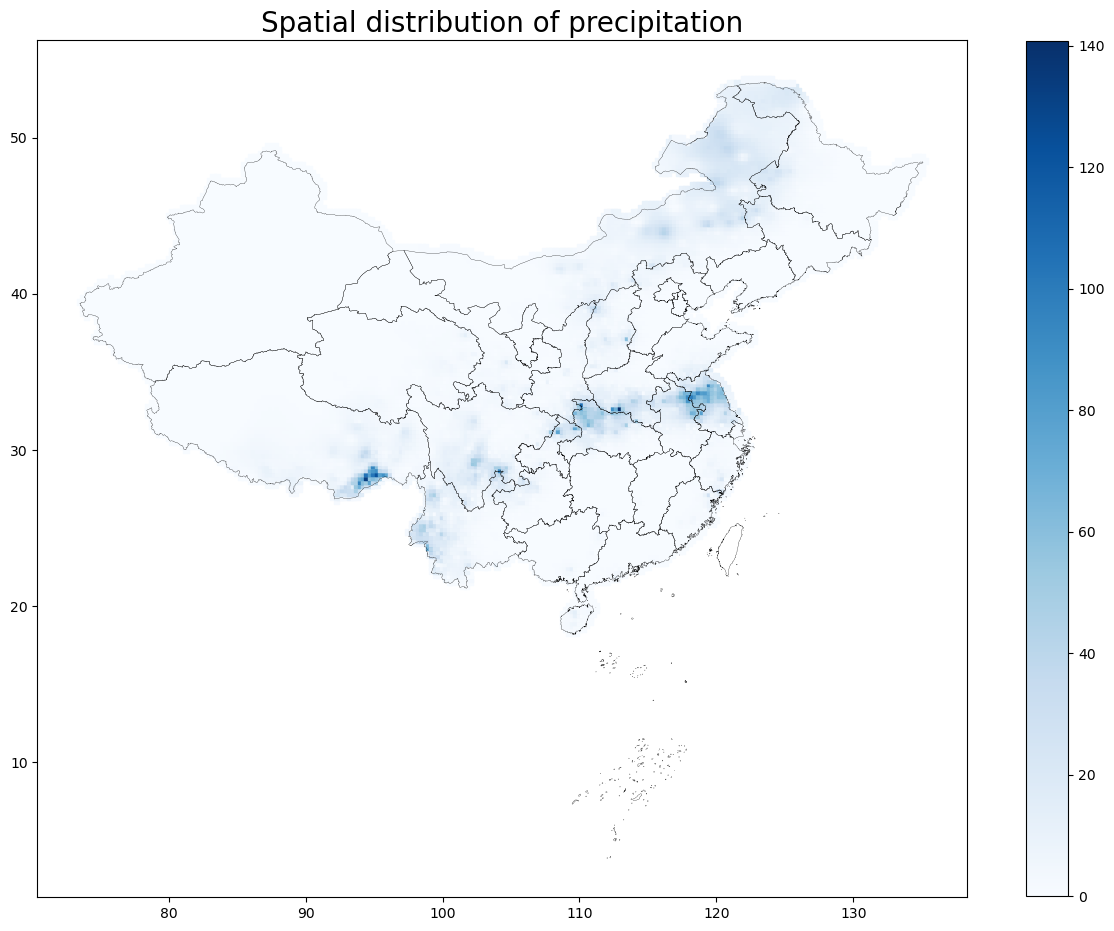

In [6]:
ax = gdf0.plot(column='2020-08-08', marker='s', markersize=17, cmap='Blues', figsize=(15,15))
gdf.boundary.plot(color='k', lw=.2, ax=ax)
plt.title('Spatial distribution of precipitation', fontsize=20)
cbar = plt.colorbar(ax.get_children()[0], shrink=0.74)
plt.show()

In [2]:
# 定义季节
spring = ['03','04','05']
summer = ['06','07','08']
autumn = ['09','10','11']
winter = ['12','01','02']

In [3]:
# 按照四季分割数据集
tif_dir = 'data/0.25 Degree Rain(1961-2022)/TIF/'
tifs = os.listdir(tif_dir)

spring_tifs = [tif for tif in tifs if tif.split('-')[1] in spring]
summer_tifs = [tif for tif in tifs if tif.split('-')[1] in summer]
autumn_tifs = [tif for tif in tifs if tif.split('-')[1] in autumn]
winter_tifs = [tif for tif in tifs if tif.split('-')[1] in winter]

In [ ]:
# compute_averages(tif_dir, spring_tifs, 5)